In [1]:
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn.functional as F
import torch.nn as nn
import pcl
import pcl_util
import time
import imageio
from IPython.display import clear_output
import matplotlib.patches

In C:\Users\Frank\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\Users\Frank\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\Frank\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\Users\Frank\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\Frank\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
"""
Load in the example data
"""

path = './imgs/data_ski/'

imgFileName  = path+'images/frame_{:04d}.png'
csvFileName  = path+'annotation/annotation_p0002_c03_f{:06d}.csv'

frame_start = 2184
frame_end = 2225

In [3]:
"""
This section of the code is for processing/obtaining the inputs for PCL
Defining the Parameters that PCL requires given as [unit; dimensions]:
    - N = batch size or number of examples
    - Crop Positions            [pixels; Nx2]       
    - Crop Scales               [pixels; Nx2]
    - Camera Matrix             [pixels; Nx3x3]
"""

crop_resolution_px = torch.Size([600, 800])

image_resolution_px = torch.FloatTensor([2704, 1520])

points_start = 2181
positions_px = torch.FloatTensor([
    [18, 214],[52, 224],[90, 240],[88, 244],[130, 250],[168, 266],[204, 280],[238, 290],[282, 304],[322, 318],[362, 330],[400, 348],[446, 364],[490, 378],[534, 390],[576, 408],
    [620, 422],[664, 436],[710, 448],[756, 466],[804, 488],[854, 496],[900, 512],[952, 530],[996, 554],[1054, 560],[1106, 578],[1159, 592],[1210, 614],[1268, 634],[1322, 650],[1384, 664],
    [1444, 690],[1504, 706],[1568, 726],[1634, 742],[1698, 764],[1762, 788],[1838, 800],[1908, 826],[1985, 850],[2066, 876],[2142, 896],[2224, 928],[2312, 952],[2396, 976],[2494, 1002],[2592, 1036],
    [2690, 1060],[2842, 1114]])
num_points = len(positions_px)

positions_px = pcl_util.gaussianSmooth(positions_px)

# convert to pytorch positions (-1..1 with y pointing downwards)
positions = 2 * positions_px / image_resolution_px - 1

# intrinsics
Ks_px = torch.FloatTensor([
     [1234.60,  0.0,  1348.20],
     [0.0,  1234.65,  761.74],
     [0.0,      0.0,  1.0]])

# select the same camera for all frames
Ks_px = Ks_px.unsqueeze(0).expand([num_points,3,3])
Ks = pcl_util.K_px2K_torch(Ks_px, image_resolution_px)

scales = torch.stack([torch.linspace(0.08, 0.12, steps=num_points),
                      torch.linspace(0.12, 0.20, steps=num_points)], dim=1)

scales_px = scales * image_resolution_px

"""MANUAL DEFINITION OF AFFINE TRANFORM FOR COMPARISON"""
# baseline, affine crop grid
size_affine = torch.Size([num_points, 3, crop_resolution_px[1], crop_resolution_px[0]])
affine_matrix = torch.zeros([num_points,2,3])
affine_matrix[:,0,0] = scales[:,0]
affine_matrix[:,1,1] = scales[:,1]
affine_matrix[:,:2,2] = positions
grid_affine = F.affine_grid(affine_matrix, size=size_affine, align_corners=True)


In [4]:
"""
This section of code shows how we use PCL to obtain a persepctive crop of the image
"""

# run PCL
P_virt2orig, R_virt2orig, K_virt = pcl.pcl_transforms(positions_px, scales_px, Ks_px)
# R_orig2virt = R_virt2orig.permute([0, 2, 1])
R_orig2virt = torch.inverse(R_virt2orig)

# generate perspective grid
# grid_perspective = pcl.perspective_grid(P_virt2orig, torch.tensor([2704, 1520]), [crop_resolution_px[0], crop_resolution_px[1]], transform_to_pytorch=True)
grid_perspective = pcl.perspective_grid(P_virt2orig, image_resolution_px, crop_resolution_px, transform_to_pytorch=True)

# similarily, we can define the affine_grid in a similar manner
grid_affine = F.affine_grid(affine_matrix, size=size_affine, align_corners=True)


In [5]:
def plotPerspectiveCrop(ax_img, i, positions, scales, width, height, Ks, position_py, scale_py, Ks_py, lwidth=1, c_persp="blue", c_affine = "red"):
    """
    This function visualizes the PCL and Affine crop on top of the original image
    """    
    P_virt2orig, R_virt2orig, K_virt = pcl.pcl_transforms(positions, scales, Ks)
    grid_sparse = pcl.perspective_grid(P_virt2orig, torch.tensor([2704, 1520]), torch.Size([3, 3]), transform_to_pytorch=True)

    # convert back from pytorch coordinates
    xv = (grid_sparse[i,:,:,0].numpy()+1)/2 * width
    yv = (grid_sparse[i,:,:,1].numpy()+1)/2 * height

    ax_img.plot(xv,yv,'-',linewidth=lwidth,color=c_persp)
    ax_img.plot(xv.transpose(),yv.transpose(),'-',linewidth=lwidth,color=c_persp)

    # plot rectangular crop
    rect = matplotlib.patches.Rectangle(
        (width  * ((position_py[i,0]+1)/2-scale_py[i,0]/2), height * ((position_py[i,1]+1)/2-scale_py[i,1]/2)),
        scale_py[i,0] * width, scale_py[i,1] * height,
        linewidth=lwidth, linestyle='dashed', edgecolor=c_affine, facecolor='none')
    ax_img.add_patch(rect)

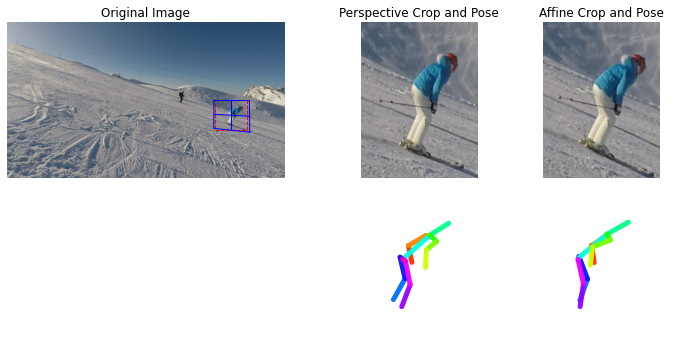

In [6]:
%matplotlib inline

"""
Here we visualize a sequence where a person is skiing down a hill. In the output, you should see that the "Perspective Pose" always
matches the "Perspective Crop" from the image while the affine crop with the unaltered 3D ground truth poses are only aligned when the person
is at the center of the image.
"""

# loop over all images and apply PCL
for f in range(frame_start, frame_end, 1):
    #relative_duration = (f-frame_start) / (frame_end - frame_start)
    i = f - points_start
    print("processing frame {}".format(f))

    # read 3D gt annotation
    with open(csvFileName.format(f), 'r') as ground_truth_file:
        csv_reader = csv.reader(ground_truth_file)
        for line in csv_reader:
            pose_3d_c = [float(elem) for elem in line[0:]]

    # Visualize the GT 3d pose
    pose_3d_c = torch.FloatTensor(pose_3d_c).view([-1,3])[pcl_util.cpm_2_h36m, :]
    pose_3d_c -= torch.mean(pose_3d_c, dim=0) # hip-center

    # visualize the GT 3d pose in the virtual coordinates (Which would be the output of the model using PCL processed inputs)
    pose_3d_v = (R_orig2virt[i] @ pose_3d_c.t()).t()
    
    # load image
    img_orig = torch.FloatTensor(imageio.imread(imgFileName.format(f)))/256

    img_torch = img_orig.permute([2, 0, 1])

    # sample each image separately
    img_crop_perspective = F.grid_sample(img_torch.unsqueeze(0), grid_perspective[i].unsqueeze(0), align_corners=True)[0].permute([1,2,0])
    img_crop_affine = F.grid_sample(img_torch.unsqueeze(0), grid_affine[i].unsqueeze(0), align_corners=True)[0].permute([1,2,0])   

    # define plot axes
    clear_output(wait=True)
    fig = plt.figure(figsize=(10,5))
    ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((2, 4), (0, 2),)
    ax3 = plt.subplot2grid((2, 4), (0, 3),)
    ax2p = fig.add_subplot(2, 4, 7, projection='3d')
    ax3p = fig.add_subplot(2, 4, 8, projection='3d')

    # plot bounding box overlays
    ax1.imshow(img_orig, aspect='equal')
    height, width = img_orig.shape[0], img_orig.shape[1]
    plotPerspectiveCrop(ax1, i, positions_px, scales_px, height=img_orig.shape[0], width=img_orig.shape[1], Ks=Ks_px, \
        position_py=positions, scale_py=scales, Ks_py=Ks)
    ax1.set_xlim(0, width)
    ax1.set_ylim(height, 0)  # Note, first argument is height, otherwise the image is flipped...
    ax1.set_title('Original Image')

    # plot crops
    ax2.imshow(img_crop_perspective)
    ax2.set_title('Perspective Crop and Pose')

    ax3.imshow(img_crop_affine)
    ax3.set_title('Affine Crop and Pose')
    
    for ax in (ax1, ax2, ax3): ax.set_axis_off()
    plt.tight_layout()

    # plot skeletons
    pcl_util.plot_3Dpose(ax2p, pose_3d_v)
    pcl_util.plot_3Dpose(ax3p, pose_3d_c)

    plt.show()